<a href="https://colab.research.google.com/github/patbaa/physdl/blob/master/notebooks/08/adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adversarial examples for CNNs

In [48]:
from keras.applications.vgg16 import VGG16, decode_predictions 
from keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_VGG19

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inceptionv3


from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import json

%matplotlib inline

#### We will need the imageNET categories with their index for each category.

In [3]:
!wget -q https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
classes = open('imagenet_class_index.json').read()
classDF = pd.DataFrame(json.loads(classes)).T.reset_index()
classDF.pop(0);
classDF.columns = ['index', 'className']
classDF.head(3)

,index,className
0,0,tench
1,1,goldfish
2,10,brambling


### Let's use pre-trained (on ImageNet) VGG16 network  

In [4]:
vgg16_model = VGG16()

In [5]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/8/84/Vizslaonalog.jpg
!mv Vizslaonalog.jpg vizsla.jpg

Béki Peti - Flickr url: https://www.flickr.com/photos/pbekesi/267206696/

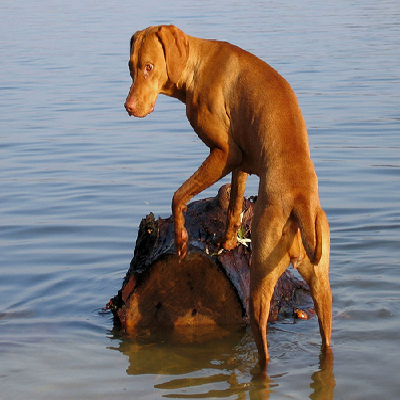

In [6]:
load_img('vizsla.jpg', target_size=(400, 400))

In [7]:
vizsla_img = load_img('vizsla.jpg', target_size=(224, 224))
vizsla_img = img_to_array(vizsla_img)[None]

#### .copy() is needed not to owerwrite the image (mean extracted images are not the good looking ones)

In [8]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(vizsla_img.copy())), 10)

[[('n02100583', 'vizsla', 0.5194956),
  ('n02090379', 'redbone', 0.23726405),
  ('n02087394', 'Rhodesian_ridgeback', 0.099828325),
  ('n02093991', 'Irish_terrier', 0.09618578),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.01605238),
  ('n02088466', 'bloodhound', 0.01205225),
  ('n02107142', 'Doberman', 0.0058248923),
  ('n02096051', 'Airedale', 0.0022655139),
  ('n02100877', 'Irish_setter', 0.0018373078),
  ('n02115641', 'dingo', 0.0010482871)]]

## Increase all pixel values one-by one and save it's affect on all the predictions!
Only one pixel is modified at a time. For each pixel modification we save the new predictions for all the categories!

In [9]:
def create_pred_list(original_img, preprocessor, model, bs=64):
    batch_images = [] # predict for a batch is faster
    pred_list    = [] # store all the predictions
    epsilon      = 3  # to distorse the original image's pixel

    for channel in range(3): # super slow loop-in-loop but OK for now
        # could have beens significantly speed up with backprop
        for i in range(224):
            for j in range(224):
                tmp = original_img.copy()
                tmp[0, i, j, channel] += epsilon
                tmp = preprocessor(tmp)
                batch_images.append(tmp[0])

                if(len(batch_images) == bs):
                    pred_list = pred_list + list(model.predict_on_batch(np.array(batch_images)))
                    batch_images = []
    return pred_list

#### This cell may run 8-15 minutes!!!

In [10]:
%%time
original_img_mask_preds = create_pred_list(vizsla_img, preprocess_input_VGG16, vgg16_model)

CPU times: user 3min 45s, sys: 1min 59s, total: 5min 45s
Wall time: 9min 49s


In [11]:
def generate_new_image(new_category, mask_weight, model, image, preprocess_input, pred_list):        
    original_pred = model.predict(preprocess_input(image.copy()))

    imagenet_index = int(classDF[classDF.className == new_category]['index'].tolist()[0])
    predictions    = np.array(pred_list)[:,imagenet_index]
    mask = np.zeros((1, 224, 224, 3))

    idx = 0
    for channel in range(3): 
        for i in range(224):
            for j in range(224):
                if(predictions[idx] >  original_pred[0][imagenet_index]):   
                    # if we got closer to the category -> 1
                    mask[0, i, j, channel] = 1
                elif(predictions[idx] <  original_pred[0][imagenet_index]): 
                    # if we got further from the category -> -1 (if didn't change it is 0)
                    mask[0, i, j, channel] = -1
                idx += 1
                
    new_img = (image[0] + mask_weight*mask[0]).copy().clip(0,255)
    return new_img.astype(np.uint8)

In [12]:
def plot_img_diff(img1, img2):
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.suptitle('Original image / DIFF / new image', fontsize=20)
    plt.subplot('131')
    plt.imshow(img1)
    plt.axis('off')

    plt.subplot('132')
    plt.imshow(img1-img2)
    plt.axis('off')

    plt.subplot('133')
    plt.imshow(img2)
    plt.axis('off')
    
    plt.show()

In [13]:
def get_preds(cat1, cat2, preprocessor, model, img):
    preds = model.predict(preprocessor(img.copy()))
    print(cat1, '\t', np.round(preds[0][int(classDF[classDF.className == cat1]['index'].tolist()[0])], 6))
    print(cat2, '\t', np.round(preds[0][int(classDF[classDF.className == cat2]['index'].tolist()[0])], 6))

# Let's try to convert the vizsla to rhodesian ridgeback
#### afrikai oroszlánkutya

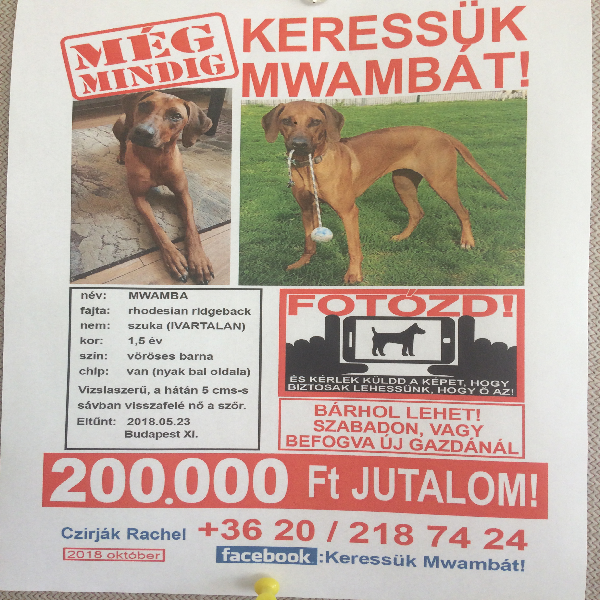

In [14]:
!wget -q patbaa.web.elte.hu/mwamba.jpg
load_img('mwamba.jpg', target_size=(600, 600)).rotate(-90)

Original predictions:
vizsla 	 0.519496
Rhodesian_ridgeback 	 0.099828


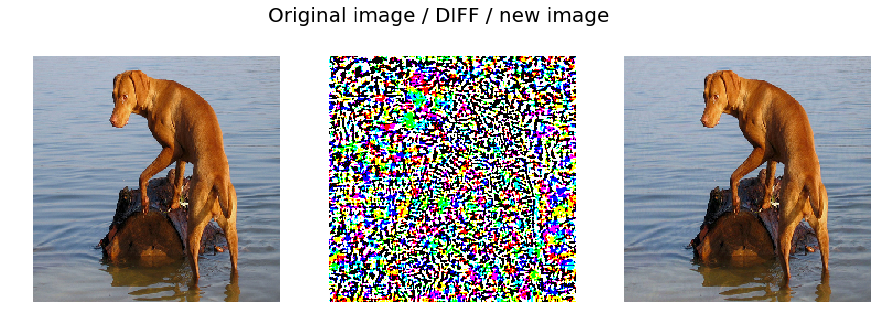

Hacked predictions
vizsla 	 0.002361
Rhodesian_ridgeback 	 0.943177


In [15]:
new_cat = 'Rhodesian_ridgeback'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

ridgeback_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                                   preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), ridgeback_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, ridgeback_img[None])

### Why do we see many colors if the mask contains only -1;0;1s?

In [16]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((vizsla_img - ridgeback_img[None]).copy())), 5)

[[('n03590841', "jack-o'-lantern", 0.03928405),
  ('n04286575', 'spotlight', 0.03413813),
  ('n03637318', 'lampshade', 0.033185866),
  ('n03196217', 'digital_clock', 0.03150917),
  ('n03729826', 'matchstick', 0.02993606)]]

In [17]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((ridgeback_img[None] - vizsla_img).copy())), 5)

[[('n03590841', "jack-o'-lantern", 0.041113622),
  ('n03637318', 'lampshade', 0.03414849),
  ('n04286575', 'spotlight', 0.03203522),
  ('n03196217', 'digital_clock', 0.029370673),
  ('n03666591', 'lighter', 0.028580302)]]

Original predictions:
vizsla 	 0.519496
Doberman 	 0.005825


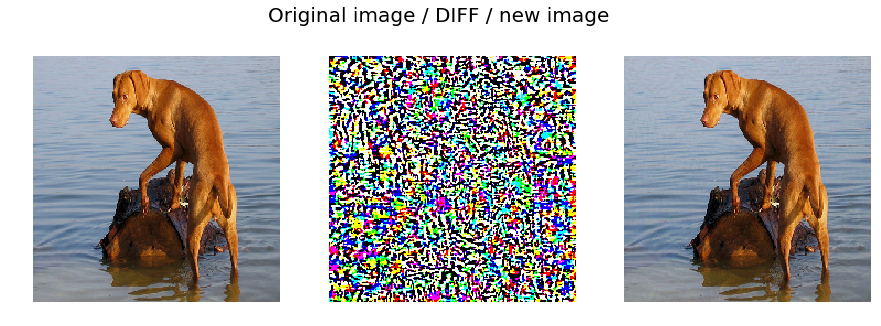

Hacked predictions
vizsla 	 0.013014
Doberman 	 0.53662


In [18]:
new_cat = 'Doberman'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

doberman_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                                  preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), doberman_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, doberman_img[None])

In [19]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((vizsla_img - doberman_img[None]).copy())), 5)

[[('n03590841', "jack-o'-lantern", 0.03695684),
  ('n04286575', 'spotlight', 0.033155),
  ('n03196217', 'digital_clock', 0.03127566),
  ('n03666591', 'lighter', 0.031026572),
  ('n03729826', 'matchstick', 0.030537948)]]

Original predictions:
vizsla 	 0.519496
brown_bear 	 1.4e-05


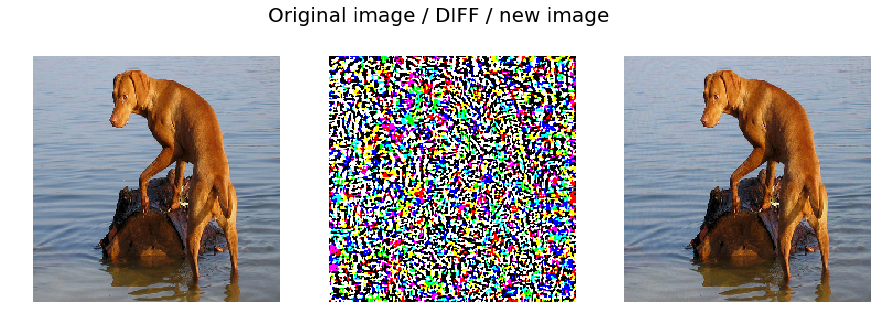

Hacked predictions
vizsla 	 0.00228
brown_bear 	 0.355671

What are the top predictions now?


[[('n02132136', 'brown_bear', 0.35567105),
  ('n02134084', 'ice_bear', 0.1672473),
  ('n02363005', 'beaver', 0.11764937),
  ('n02093991', 'Irish_terrier', 0.07154351),
  ('n02442845', 'mink', 0.044362295)]]

In [20]:
new_cat = 'brown_bear'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

bear_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                              preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), bear_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, bear_img[None])
print('\nWhat are the top predictions now?')
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(bear_img[None].copy())), 5)

# For an initially very unlikely class this doesn't work. 

Original predictions:
vizsla 	 0.519496
toilet_tissue 	 0.0


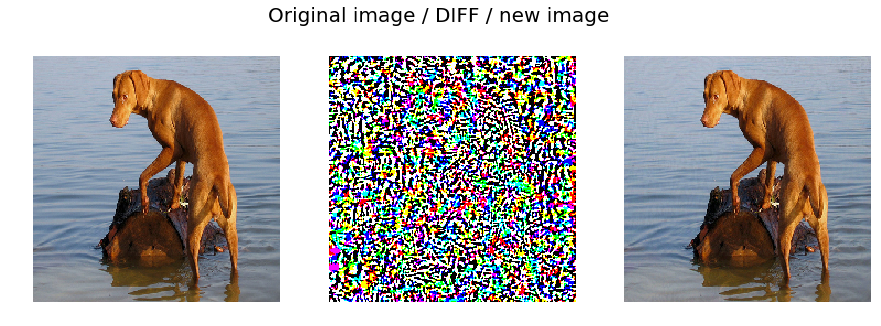

Hacked predictions
vizsla 	 0.013249
toilet_tissue 	 0.005429


[[('n02093991', 'Irish_terrier', 0.12552077),
  ('n02356798', 'fox_squirrel', 0.047551613),
  ('n02090379', 'redbone', 0.0325206),
  ('n02087394', 'Rhodesian_ridgeback', 0.025602033),
  ('n02442845', 'mink', 0.023861399)]]

In [21]:
new_cat = 'toilet_tissue'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

tissue_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                                  preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), tissue_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, tissue_img[None])
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(tissue_img[None].copy())), 5)

Original predictions:
vizsla 	 0.519496
iPod 	 0.0


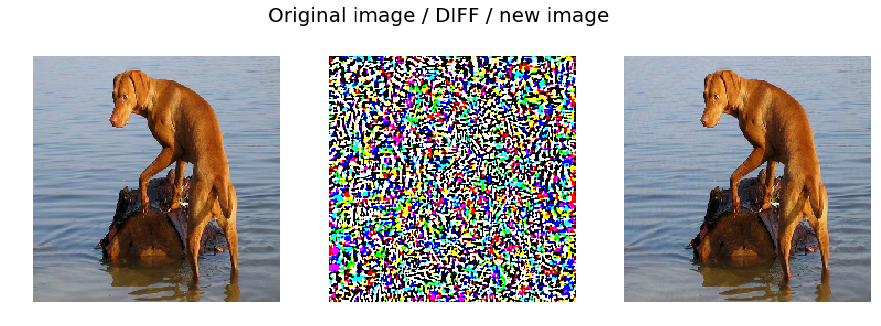

Hacked predictions
vizsla 	 0.008842
iPod 	 0.000702


[[('n02093991', 'Irish_terrier', 0.13241778),
  ('n02356798', 'fox_squirrel', 0.0932817),
  ('n02363005', 'beaver', 0.05203314),
  ('n02096051', 'Airedale', 0.050214484),
  ('n02134084', 'ice_bear', 0.029787038)]]

In [22]:
new_cat = 'iPod'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

ipod_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                                  preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), ipod_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, ipod_img[None])
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(ipod_img[None].copy())), 5)

### We didn't manage to make the vizsla iPod, but still we could 'devizslaize' the image.

### Usually we do not have access to all the predictions and there is no way trying 224\*224\*3 times...

#### But would these 'home-made' masks work on unseen networks?

In [23]:
vgg19_model = VGG19()

In [24]:
decode_predictions(vgg19_model.predict(preprocess_input_VGG19(vizsla_img.copy())), top=5)

[[('n02100583', 'vizsla', 0.8596322),
  ('n02087394', 'Rhodesian_ridgeback', 0.07811302),
  ('n02090379', 'redbone', 0.043273132),
  ('n02093991', 'Irish_terrier', 0.005052105),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.0033731614)]]

In [25]:
decode_predictions(vgg19_model.predict(preprocess_input_VGG19((ridgeback_img[None]).copy())), top=5)

[[('n02087394', 'Rhodesian_ridgeback', 0.56655174),
  ('n02100583', 'vizsla', 0.29854354),
  ('n02090379', 'redbone', 0.08588269),
  ('n02107142', 'Doberman', 0.014799278),
  ('n02093991', 'Irish_terrier', 0.007921838)]]

In [26]:
decode_predictions(vgg19_model.predict(preprocess_input_VGG19((doberman_img[None]).copy())), top=5)

[[('n02100583', 'vizsla', 0.42423612),
  ('n02087394', 'Rhodesian_ridgeback', 0.24876058),
  ('n02107142', 'Doberman', 0.10970824),
  ('n02090379', 'redbone', 0.060039528),
  ('n02093991', 'Irish_terrier', 0.03469103)]]

[[('n02107142', 'Doberman', 0.163381),
  ('n02087394', 'Rhodesian_ridgeback', 0.11802992),
  ('n02093991', 'Irish_terrier', 0.08881648),
  ('n02093428', 'American_Staffordshire_terrier', 0.07383772),
  ('n02100583', 'vizsla', 0.06828485)]]

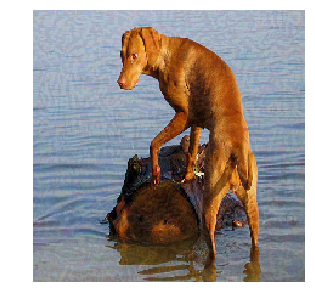

In [27]:
new_img = ((doberman_img[None] - vizsla_img)*3 + vizsla_img).clip(0,255).copy().astype(np.uint8)
plt.imshow(new_img[0].astype(np.uint8))
plt.axis('off')
decode_predictions(vgg19_model.predict(preprocess_input_VGG19(new_img.copy())), top=5)

In [28]:
!wget -q https://www.researchgate.net/profile/Masoud_Mahdianpari/publication/326421398/figure/fig4/AS:649352863301634@1531829195262/Schematic-diagram-of-a-VGG16-and-b-VGG19-models.png
!mv Schematic-diagram-of-a-VGG16-and-b-VGG19-models.png vgg.png

Credits: Masoud Mahdianpari et al, 2018
VGG16 (a) and VGG19 (b)


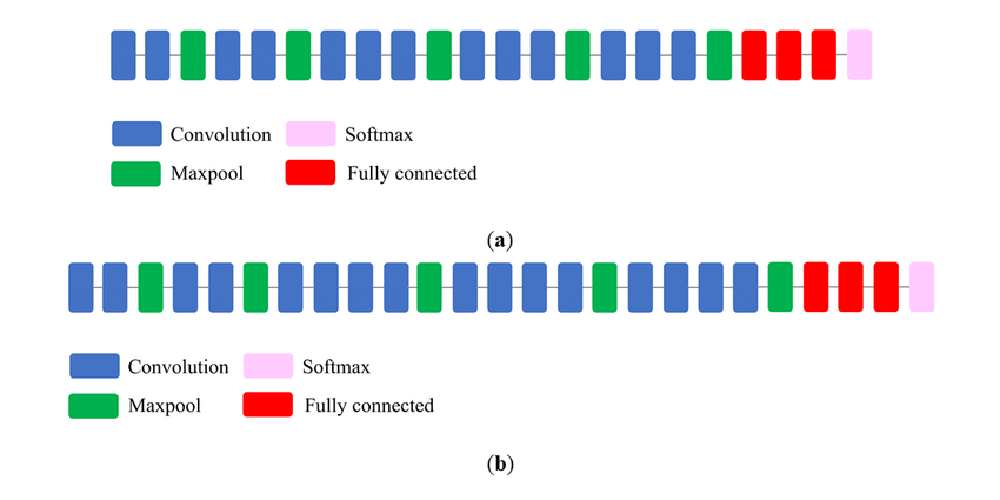

In [29]:
print('Credits: Masoud Mahdianpari et al, 2018')
print('VGG16 (a) and VGG19 (b)')
load_img('vgg.png', target_size=(500, 1000))

## OK, but VGG16 and VGG19 are 'almost the same', what about an other network?

In [30]:
!wget -q https://www.researchgate.net/profile/Masoud_Mahdianpari/publication/326421398/figure/fig6/AS:649353890889730@1531829440919/Schematic-diagram-of-InceptionV3-model-compressed-view.png
!mv Schematic-diagram-of-InceptionV3-model-compressed-view.png inception.png

Credits: Masoud Mahdianpari et al, 2018
InceptionV3


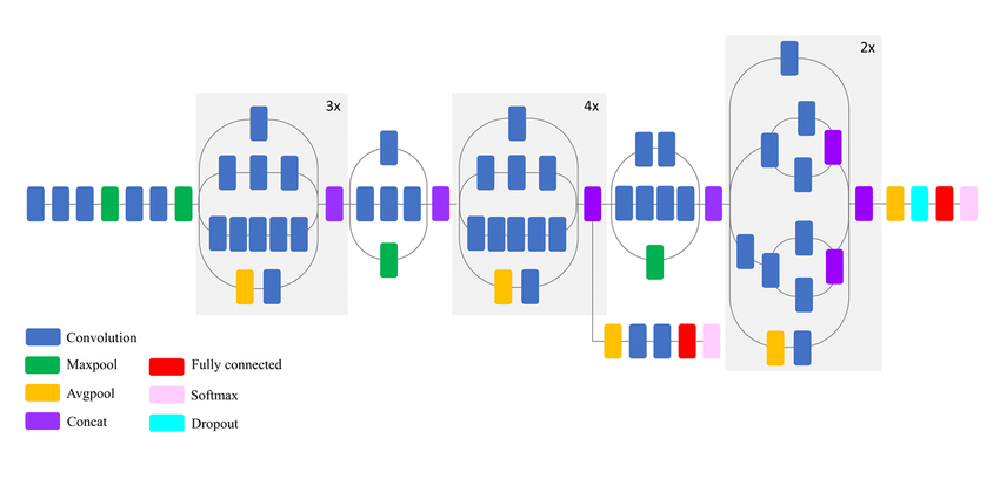

In [31]:
print('Credits: Masoud Mahdianpari et al, 2018')
print('InceptionV3')
load_img('inception.png', target_size=(500, 1000))

In [32]:
inceptionv3_model = InceptionV3()

In [33]:
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3(vizsla_img.copy())), top=5)

[[('n02087394', 'Rhodesian_ridgeback', 0.59729373),
  ('n02100583', 'vizsla', 0.40218133),
  ('n02090379', 'redbone', 0.0003098936),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.00012456399),
  ('n02099712', 'Labrador_retriever', 1.930414e-05)]]

In [34]:
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3((ridgeback_img[None]).copy())), top=5)

[[('n02087394', 'Rhodesian_ridgeback', 0.76026875),
  ('n02100583', 'vizsla', 0.23947753),
  ('n02090379', 'redbone', 0.00016880414),
  ('n02099849', 'Chesapeake_Bay_retriever', 2.2258198e-05),
  ('n07754684', 'jackfruit', 1.6835565e-05)]]

[[('n02100583', 'vizsla', 0.99544865),
  ('n02087394', 'Rhodesian_ridgeback', 0.0041602226),
  ('n02090379', 'redbone', 0.00019675026),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.00017280305),
  ('n02099712', 'Labrador_retriever', 5.599363e-06)]]

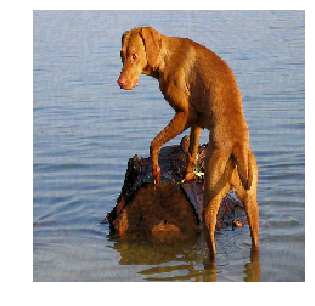

In [35]:
new_img = ((ridgeback_img[None] - vizsla_img)*-2 + vizsla_img).clip(0,255).copy().astype(np.uint8)
plt.imshow(new_img[0].astype(np.uint8))
plt.axis('off')
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3(new_img.copy())), top=5)

In [36]:
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3((bear_img[None]).copy())), top=5)

[[('n02087394', 'Rhodesian_ridgeback', 0.9068477),
  ('n02100583', 'vizsla', 0.07848565),
  ('n02090379', 'redbone', 0.008995245),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.0041916356),
  ('n02099712', 'Labrador_retriever', 0.0010846814)]]

[[('n02132136', 'brown_bear', 0.58956987),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.31426728),
  ('n02115641', 'dingo', 0.06949644),
  ('n02100583', 'vizsla', 0.012283308),
  ('n02129165', 'lion', 0.001942942)]]

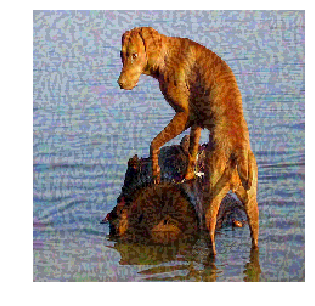

In [37]:
new_img = ((bear_img[None] - vizsla_img)*7 + vizsla_img).clip(0,255).copy().astype(np.uint8)
plt.imshow(new_img[0].astype(np.uint8))
plt.axis('off')
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3(new_img.copy())), top=5)

### The problem can generalize across different architectures.
 - they were trained on the data dataset to mimic the same function/decision boundary

# Read more: 
 - https://blog.openai.com/adversarial-example-research/  
 - https://blog.openai.com/robust-adversarial-inputs/        

In [38]:
!wget -q https://www.zoo-berlin.de/fileadmin/_processed_/8/3/csm_Meng_Meng_Baby_1_0b7fe14b2b.jpg
!mv csm_Meng_Meng_Baby_1_0b7fe14b2b.jpg panda.jpg

panda_img = load_img('panda.jpg', target_size=(224, 224))
panda_img = img_to_array(panda_img)[None]

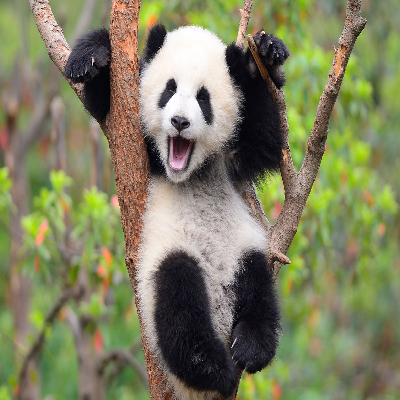

In [39]:
load_img('panda.jpg', target_size=(400, 400))

In [40]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((panda_img).copy())), top=5)

[[('n02510455', 'giant_panda', 0.8348406),
  ('n02509815', 'lesser_panda', 0.029610712),
  ('n02412080', 'ram', 0.02029823),
  ('n02483362', 'gibbon', 0.018874291),
  ('n02500267', 'indri', 0.0155836865)]]

Probably that's why they choose 'gibbon' and not 'iPod'.